In [1]:
import numpy as np 
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt

import sys
sys.path.append('../utils')

from text.utils import save_text_state, load_text_state, build_text_state, load_books
from model.utils import get_device, load_model_state, save_model_state, build_model_state

from text_model import TextModel, get_loss_function

### Verify if CUDA is available

In [2]:
device = get_device()
print(device)

cuda


### Loading word vectors and training/validation dataset

In [3]:
LOAD_CHECKPOINTS = True

CHECKPOINT_BASE = 'checkpoints'
DATASET_FILENAME = '../datasets/books.pk'
AUTHOR = 'Ernest Hemingway'

VAL_PARTITION = 0.3 
MAX_SENTENCE_LENGTH = 15
MIN_SENTENCE_LENGTH = 5
BATCH_SIZE = 8

In [4]:
# Try loading dataset, if it doesn't exists then creates it
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    vocab, train_dataset, test_dataset = load_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'))    
    print('Checkpoint loaded')
except:
    books = load_books(DATASET_FILENAME, author=AUTHOR)
    vocab, train_dataset, test_dataset = build_text_state(books, MIN_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH, VAL_PARTITION, vocab_name=AUTHOR)  
    print('No checkpoint found. New partition.')
    print('Included books:')
    for book in books:
        print('\t', book)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

No checkpoint found. New partition.
Included books:
	 Name: In our time   Author: Ernest Hemingway
	 Name: The old man of the sea   Author: Ernest Hemingway
	 Name: Three stories and ten poems   Author: Ernest Hemingway


In [5]:
save_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'), vocab, train_dataset, test_dataset) 

### Loading components

In [6]:
VOCAB_SIZE = len(vocab)

LEARNING_RATE = 1e-4
BETA_1 = 0.1
BETA_2 = 0.999
EPOCHS = 50
NUM_HEADS = 8
ENCODER_LAYERS = 1
DECODER_LAYERS = 1
EMBEDDING_SIZE = 512
FF_DIM = 1024
DROPOUT=0.1
STEP_LR_DECAY = 15
LR_FACTOR_DECAY = 0.5

In [7]:
model = TextModel(
    vocab_size=VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE, 
    num_heads=NUM_HEADS, 
    encoder_layers=ENCODER_LAYERS, 
    decoder_layers=DECODER_LAYERS, 
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
)

optimizer = torch.optim.Adam(
    list(model.parameters()), 
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2)
)

loss_fn = get_loss_function()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_LR_DECAY, gamma=LR_FACTOR_DECAY)

In [8]:
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    model, optimizer, last_epoch, train_loss_history, val_loss_history, best_val_loss = load_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
        model, 
        optimizer
    )
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    print('Checkpoint loaded')
    
except:
    last_epoch, train_loss_history, val_loss_history, best_val_loss = build_model_state()
    print('No checkpoints found. New training.')
    pass

model = model.to(device)


No checkpoints found. New training.


### Training and validation

In [9]:
def train_step(transformer, loss_fn, optimizer, batch):
    transformer.train()

    transformer.zero_grad()
    optimizer.zero_grad()

    decodings = transformer(batch[:,1:], batch[:,:-1])
    
    loss = loss_fn(batch[:,1:], decodings)
    loss.backward()
    optimizer.step()
    return loss.item()    

In [10]:
def val_step(transformer, loss_fn, batch):
    transformer.eval()
    
    with torch.no_grad():
        decodings = transformer(batch[:,1:], batch[:,:-1])
        loss = loss_fn(batch[:,1:], decodings)

        return loss.item(), decodings

In [11]:
# Define steps where examples will be sampled 
test_examples = iter(test_dataloader)

# For EPOCHS
for epoch in range(last_epoch + 1, EPOCHS + last_epoch):
    
    print('*************************** EPOCH {} ***************************'.format(epoch))

    # Restart train dataset
    examples = iter(train_dataloader)

    # Progress bar for training dataset
    progress_bar = tqdm(range(len(train_dataloader)))
    train_loss = 0

    # For all data in training dataset
    # Training
    for batch_idx in progress_bar:

        # Add train loss to progress bar
        progress_bar.set_postfix({
            'tr_loss': train_loss / (batch_idx + 1), 
            'lr': scheduler.get_lr()[0]
        })

        # Train step
        example = next(examples).to(device)
        train_loss += train_step(model, loss_fn, optimizer, example)


        if batch_idx == 0:
            try:
                example = next(test_examples).to(device)
            except:
                test_examples = iter(test_dataloader)
                example = next(test_examples).to(device)

            with torch.no_grad():
                _, decodings = val_step(model, loss_fn, example)
                decodings = torch.argmax(decodings[0], dim=-1).cpu().numpy()

            print('\nReal: {}'.format( ' '.join(vocab.to_words(example[0][1:].cpu().numpy())) ))
            print('Decoded: {}'.format( ' '.join(vocab.to_words(decodings))))

    # Validation
    val_examples = iter(test_dataloader)
    progress_bar = tqdm(range(len(test_dataloader)))
    val_loss = 0

    for batch_idx in progress_bar:
        progress_bar.set_postfix({
            'val_loss': val_loss / (batch_idx + 1)
        })
        
        example = next(val_examples).to(device)
        
        with torch.no_grad():
            val_loss += val_step(model, loss_fn, example)[0]
    
    # Save losses in history
    train_loss_history.append(train_loss / len(train_dataloader))
    val_loss_history.append(val_loss / len(test_dataloader))
    
    # If this model is best than other
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_model_state(
            os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
            model, 
            optimizer, 
            epoch, 
            train_loss_history, 
            val_loss_history, 
            best_val_loss
        )
        
    # Save last model
    save_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_last.pt'), 
        model, 
        optimizer, 
        epoch, 
        train_loss_history, 
        val_loss_history, 
        best_val_loss
    )    
    
    scheduler.step()    

*************************** EPOCH 1 ***************************



Real: the <unk> moved further up the line <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: the the the the the the the the the the the the the the the the




*************************** EPOCH 2 ***************************



Real: then he added , blessed <unk> , pray for the death of this fish <pad> <eos>
Decoded: the the the the the the the the the the the the the the the <eos>




*************************** EPOCH 3 ***************************



Real: jim <unk> and <unk> a little <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: he he he he he he he the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 4 ***************************



Real: good luck , the old man said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: the , , the fish fish of <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 5 ***************************



Real: the <unk> <unk> a <unk> — driving , throbbing , <unk> <pad> <pad> <pad> <pad> <eos>
Decoded: the old to a said the <pad> , the , said <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 6 ***************************



Real: i saw them coming and <unk> at my old man as he went by and <eos>
Decoded: i do them now and on at on old man as he you now and <eos>




*************************** EPOCH 7 ***************************



Real: every day is a new day <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: to up is a fish him <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 8 ***************************



Real: then he <unk> the mast and started to climb <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: then he started the other and started to eat <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 9 ***************************



Real: <unk> everyone would have wanted it to go to a <unk> <pad> <pad> <pad> <pad> <eos>
Decoded: nothing nothing would have so it to go to a time <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 10 ***************************



Real: the speed of the line was cutting his hands badly but he had always known <eos>
Decoded: the sea of the line was big his hands started but he had always looking <eos>




*************************** EPOCH 11 ***************************



Real: most people are <unk> about turtles because a turtle ' s heart will beat for <eos>
Decoded: going nothing are more about the because a re ' s started will beat for <eos>




*************************** EPOCH 12 ***************************



Real: i must have water here for him , the boy thought , and <unk> and <eos>
Decoded: i must have water onto for him , the boy thought , and clear and <eos>




*************************** EPOCH 13 ***************************



Real: the old man was sweating now but from something else besides the sun <pad> <pad> <eos>
Decoded: the old man was hooked now but from something clear side the sun <pad> <pad> <eos>




*************************** EPOCH 14 ***************************



Real: then we would have that for all of our <unk> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: then we would have that for all of men clear <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 15 ***************************



Real: after supper they went into the front room again and liz cleaned off with j <eos>
Decoded: after supper they went into the front room again and liz behind off with j <eos>




*************************** EPOCH 16 ***************************



Real: then he baited another line and left it coiled in the shade of the bow <eos>
Decoded: then he picture another line and left it clear in the door of the bow <eos>




*************************** EPOCH 17 ***************************



Real: he was quite a way up the hill <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: he was some a way up the hill <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 18 ***************************



Real: here ' s to next year <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: here ' s to next year <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 19 ***************************



Real: the walls were <unk> bright blue and were of wood and the <unk> <unk> their <eos>
Decoded: the wall were blue quarters blue and were of wood and the blue blue their <eos>




*************************** EPOCH 20 ***************************



Real: the negro ' s shadow was huge and it moved on the wall as the <eos>
Decoded: the prisms ' s although was ails and it moved on the wall as the <eos>




*************************** EPOCH 21 ***************************



Real: it turned on its side and then righted itself <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: it turned on its side and then turn faint <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 22 ***************************



Real: the fish is calm and steady <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: the fish is calm and steady <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 23 ***************************



Real: at least he carried <unk> of horses at all times in his pocket and <unk> <eos>
Decoded: at ails he carried blue of calm at all times in his pocket and blue <eos>




*************************** EPOCH 24 ***************************



Real: the old man could see pieces of the meat of the fish <unk> white from <eos>
Decoded: the old man could see quarters of the meat of the fish blue white from <eos>




*************************** EPOCH 25 ***************************



Real: he leaned over the side and pulled <unk> a piece of the meat of the <eos>
Decoded: he leaned over the side and pulled blue a piece of the meat of the <eos>




*************************** EPOCH 26 ***************************



Real: up the road a <unk> was the <unk> church and down the road the other <eos>
Decoded: up the road a blue was the blue about and down the road the other <eos>




*************************** EPOCH 27 ***************************



Real: no , the boy said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: no , the boy said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 28 ***************************



Real: the sky was <unk> over to the east and one after another the stars he <eos>
Decoded: the sky was blue over to the east and one after another the concordia he <eos>




*************************** EPOCH 29 ***************************



Real: then he started to <unk> the blanket <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: then he started to blue the blanket <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 30 ***************************



Real: he liked to think of the fish and what he could do to a shark <eos>
Decoded: he liked to think of the fish and what he could do to a shark <eos>




*************************** EPOCH 31 ***************************



Real: the great sisler ' s father was never poor and he , the father , <eos>
Decoded: the great harbour ' s father was never poor and he , the father , <eos>




*************************** EPOCH 32 ***************************



Real: it jumped again and again in the <unk> of its fear and he worked his <eos>
Decoded: it jumped again and again in the blue of its fear and he worked his <eos>




*************************** EPOCH 33 ***************************



Real: <unk> now to get some sleep , old man , while the fish is calm <eos>
Decoded: blue now to get some sleep , old man , while the fish is calm <eos>




*************************** EPOCH 34 ***************************



Real: she filled the quarter <unk> <unk> <unk> with a <unk> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: she loosened the quarter blue blue blue with a blue <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 35 ***************************



Real: that school has <unk> away from me , he thought <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: that school has blue away from me , he thought <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 36 ***************************



Real: it was <unk> and quiet , and there were other people <unk> <pad> <pad> <pad> <eos>
Decoded: it was blue and quiet , and there were other people blue <pad> <pad> <pad> <eos>




*************************** EPOCH 37 ***************************



Real: <unk> caro ! in the morning at seven <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: blue caro ! in the morning at seven <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 38 ***************************



Real: the shark lay quietly for a little while on the surface and the old man <eos>
Decoded: the shark lay quietly for a little while on the surface and the old man <eos>




*************************** EPOCH 39 ***************************



Real: santiago , the boy said to him as they climbed the bank from where the <eos>
Decoded: plastiras , the boy said to him as they climbed the bank from where the <eos>




*************************** EPOCH 40 ***************************



Real: you must do nothing <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
Decoded: you must do nothing blue <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 41 ***************************



Real: <unk> mary , mother of god , pray for us <unk> now and at the <eos>
Decoded: hail bearers , mother of god , pray for us blue now and at the <eos>




*************************** EPOCH 42 ***************************



Real: the old man <unk> the oar and put the blade between the shark ' s <eos>
Decoded: the old man blue the oar and put the blade between the shark ' s <eos>




*************************** EPOCH 43 ***************************



Real: if he does not do that maybe he will come up with the <unk> <pad> <eos>
Decoded: if he does not do that maybe he will come up with the blue <pad> <eos>




*************************** EPOCH 44 ***************************



Real: the brown blotches of the <unk> skin <unk> the sun brings from its reflection on <eos>
Decoded: the brown blotches of the blue butt blue the sun padova from its picture on <eos>




*************************** EPOCH 45 ***************************



Real: he was <unk> too and he got down on his knees and , being <unk> <eos>
Decoded: he was blue too and he got down on his knees and , being blue <eos>




*************************** EPOCH 46 ***************************



Real: there was <unk> country and <unk> each way up the road <pad> <pad> <pad> <pad> <eos>
Decoded: there was hang country and hang each way up the road <pad> <pad> <pad> <pad> <eos>




*************************** EPOCH 47 ***************************



Real: at that moment he felt him stop moving but the weight was still there <pad> <eos>
Decoded: at that moment he felt him quarters moving but the weight was still there <pad> <eos>




*************************** EPOCH 48 ***************************



Real: he <unk> the rope <unk> of the oars onto the <unk> <unk> and , <unk> <eos>
Decoded: he hang the rope blue of the oars onto the blue blue and , blue <eos>




*************************** EPOCH 49 ***************************



Real: we went to work on the <unk> and in the morning the sun came up <eos>
Decoded: we went to work on the blue and in the morning the sun came up <eos>



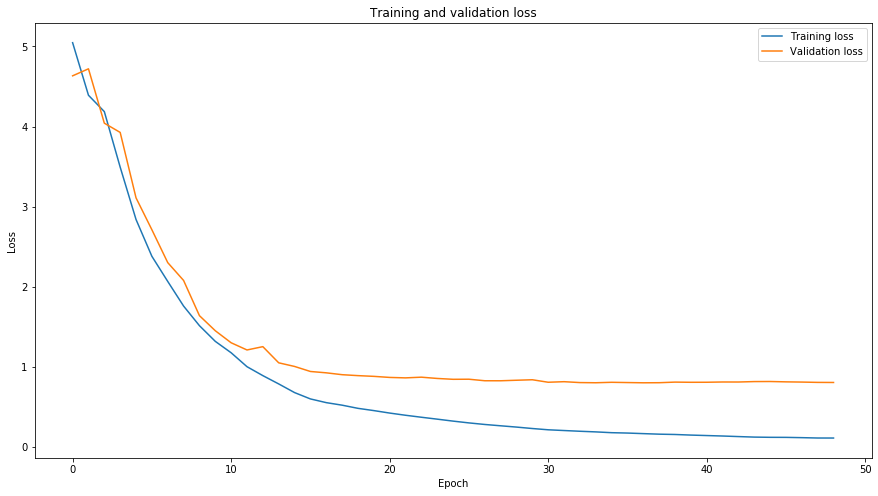

In [12]:
x = [epoch for epoch in range(len(train_loss_history))]
plt.figure(figsize=(15, 8))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.plot(x, train_loss_history, label='Training loss')
plt.plot(x, val_loss_history, label='Validation loss')

plt.legend()

plt.show()

In [13]:
argmin_val = np.argmin(val_loss_history)
print('Least validation loss: {} in epoch {}'.format(val_loss_history[argmin_val], argmin_val))

Least validation loss: 0.8028801790921085 in epoch 36
